## Importing Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import copy
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

## Reading the Dataset
The dataset is stored in a dataframe named **opec** with the column **Date** as the index.

In [2]:
opec = pd.read_csv('cleaned_opec_dataset.csv', parse_dates=['Date'], index_col='Date')

A line plot of **Value** against **Date** is shown in the following cell 

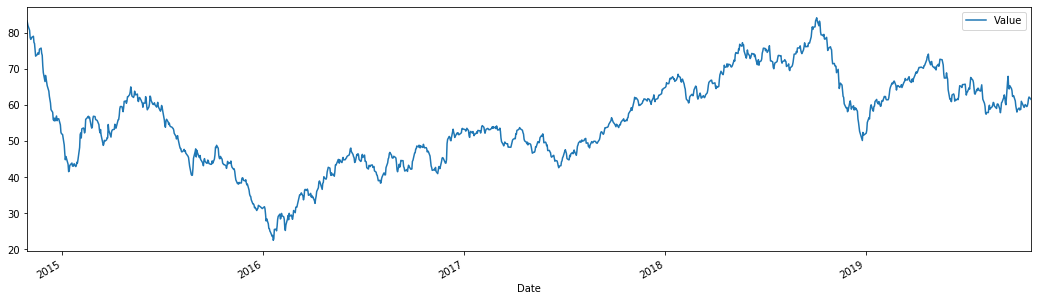

In [3]:
rcParams['figure.figsize'] = 18, 5
opec.plot()

## Defining trend for the data using a polynomial curve 
The variable **order** stores the degree of the polynomial that is supposed to define the theoretical trend of this dataset.<br>
The numpy array **coef** stores the coefficients for the polynomial whose order is defined in variable **order**.<br>
We use the **polyfit** function in numpy to fit the dataset values into a n<sup>th</sup> degree curve, where n is defined in variable **order**.<br>
Change the value of the **order** variable to get polynomial curves of diffent degrees.

In [4]:
order = 3
coef = np.polyfit(np.arange(len(opec['Value'])),
                  opec['Value'].values.ravel(),
                  order)
coef

array([ 1.79822558e-07, -3.16966662e-04,  1.21158130e-01,  5.65720626e+01])

Using the coefficients defined in **coef** variable, a polynomial model is initialized using the **poly1d** function of numpy.<br>
This model is stored in the variable **poly_mdl**

In [5]:
poly_mdl = np.poly1d(coef)
poly_mdl

poly1d([ 1.79822558e-07, -3.16966662e-04,  1.21158130e-01,  5.65720626e+01])

The pandas Series named **trend** stores the theoretical values for our dataset.

In [6]:
trend = pd.Series(data = poly_mdl(np.arange(len(opec['Value']))),
                  index = opec.index)

The following plot compares the actual datapoints with the theoretical trend obtained in the above steps.

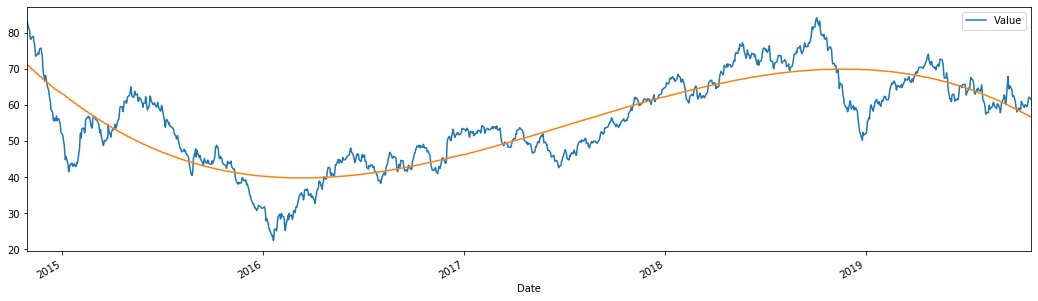

In [7]:
rcParams['figure.figsize'] = 18, 5
opec.plot()
trend.plot()
plt.show()

## Detrending the data.

Since we are implementing **Additive Decomposition**, the theoretical **trend** obtained is subtracted from the dataset to detrend the dataset.<br>
The results are stored in the variable **detrended**.

In [8]:
detrended = opec['Value'] - trend

The following line plot shows the detrended dataset

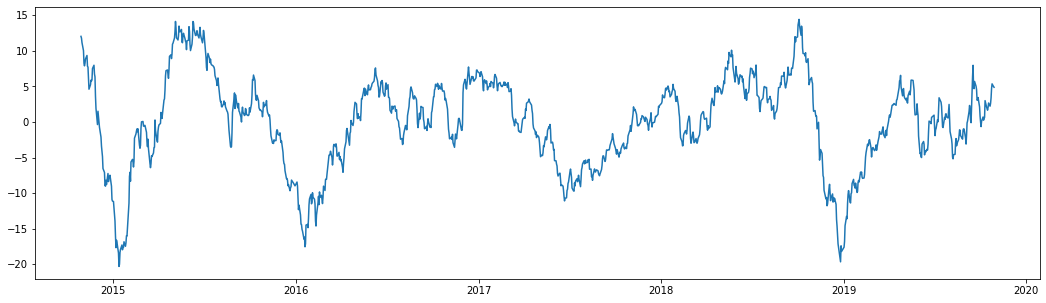

In [9]:
plt.plot(detrended)

## Extracting yearly data from the detrended data.

Here we group our detrended dataset based on **year** and plot line curves that show the trend in oil prices for each year.

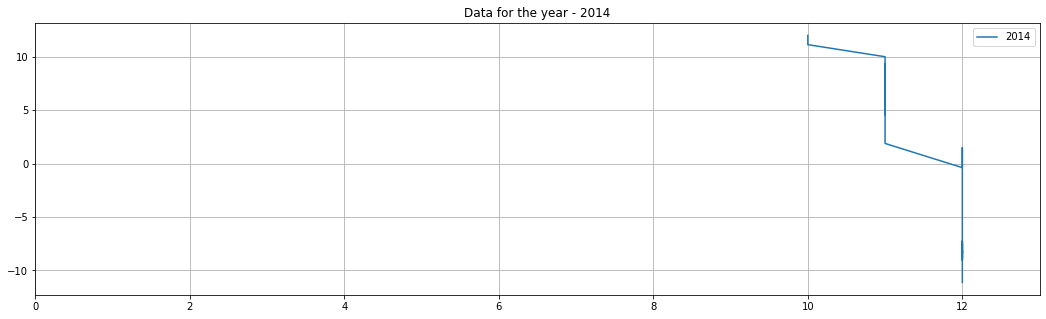

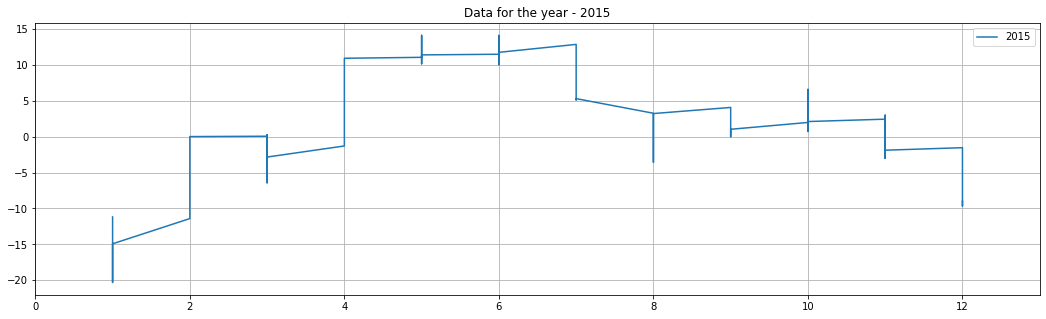

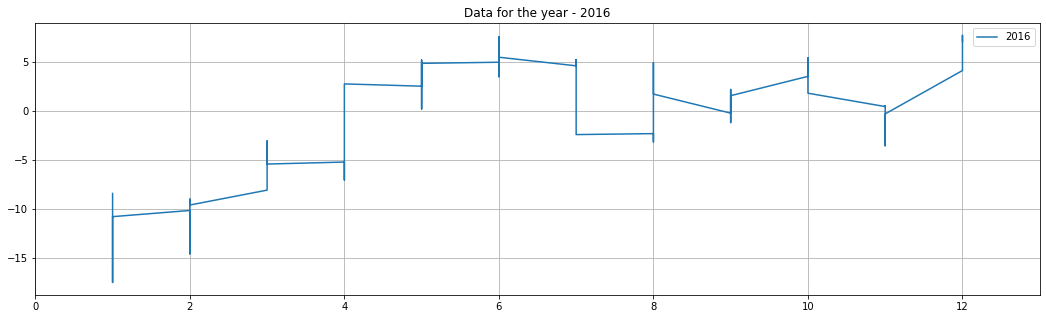

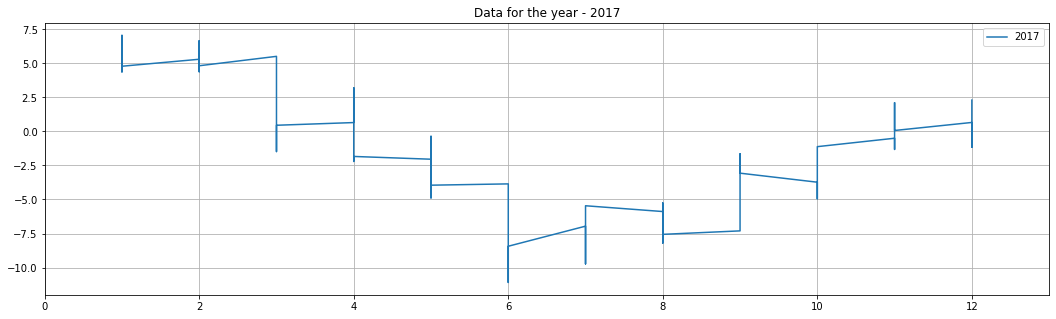

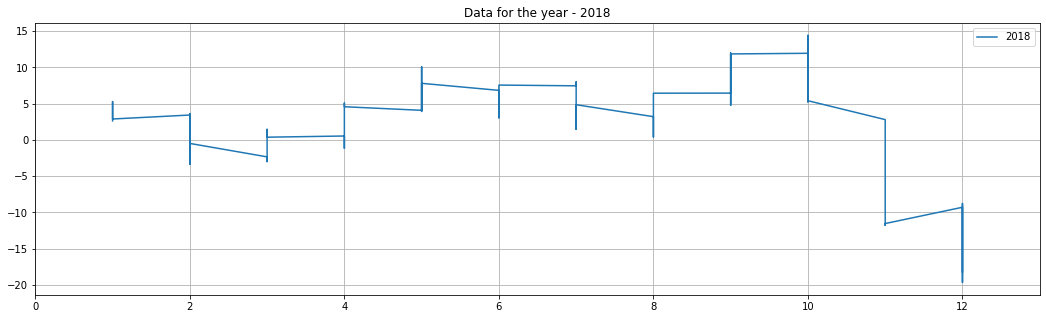

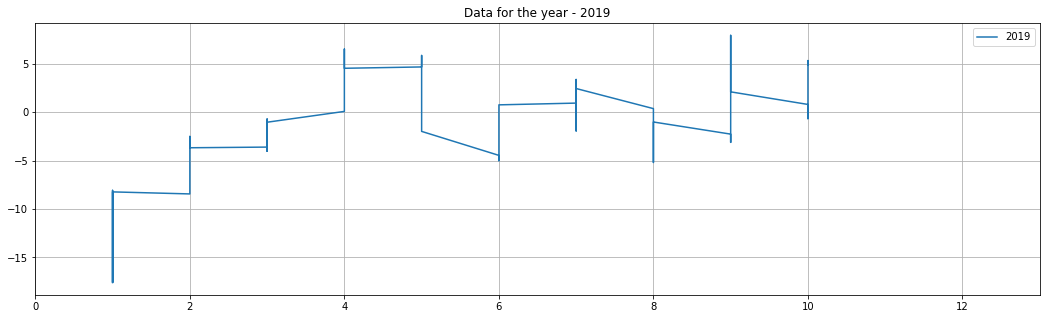

In [10]:
rcParams['figure.figsize'] = 18,5
yearly_data = detrended.groupby(by = detrended.index.year)
for year in yearly_data.groups:
    plt.plot(yearly_data.get_group(year).index.month, yearly_data.get_group(year).values, label=year)
    plt.title("Data for the year - " + str(year))
    axes = plt.gca()
    axes.set_xlim([0,13])
    plt.grid()
    plt.legend()
    plt.show()

## Defining the mean seasonality.

For each month we, take the mean of the oil prices recorded for that month each year(from 2014-2019) using the **groupby** function in pandas.<br>
The following the line plot shows the mean seasonality observed for each year.

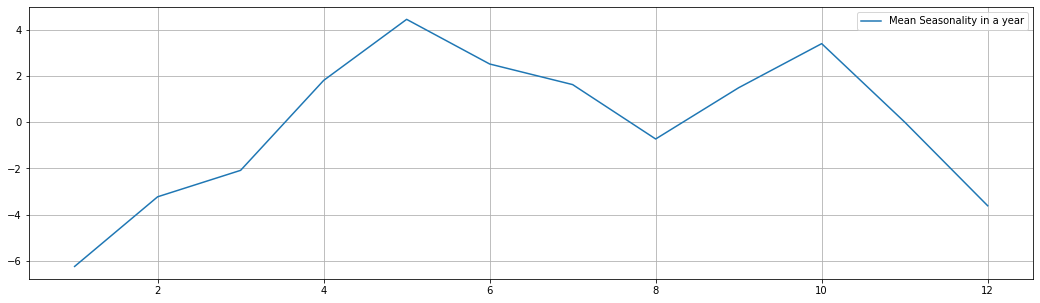

In [11]:
seasonal = detrended.groupby(by = detrended.index.month).mean()
plt.plot(seasonal, label='Mean Seasonality in a year')
plt.grid()
plt.legend()
plt.show()

This is a consolidated graph that shows the oil prices each year and the mean for each moth which depicts the mean seasonality. 

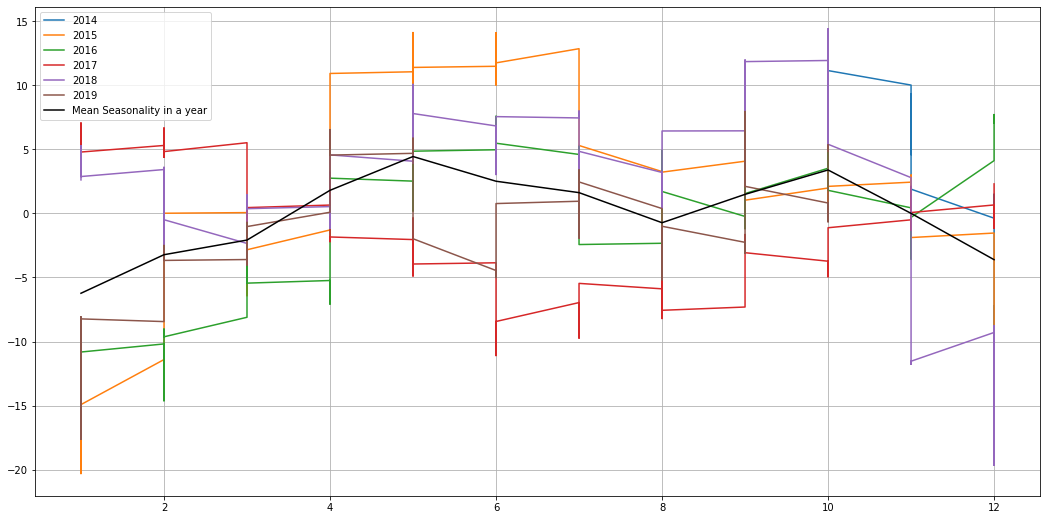

In [12]:
rcParams['figure.figsize'] = 18,9
yearly_data = detrended.groupby(by = detrended.index.year)
for year in yearly_data.groups:
    plt.plot(yearly_data.get_group(year).index.month, yearly_data.get_group(year).values, label=year)

plt.plot(seasonal, color="black", label='Mean Seasonality in a year')
plt.grid()
plt.legend()
plt.show()

## Defining the seasonality for the entire time span in the dataset. 

The **deepcopy** function generates a copy of the dataset such that changes in the copy does not affect the original dataset.<br>
On repeating the seasonality derived in the previous steps, the seasonality component for the entire dataset is generated.

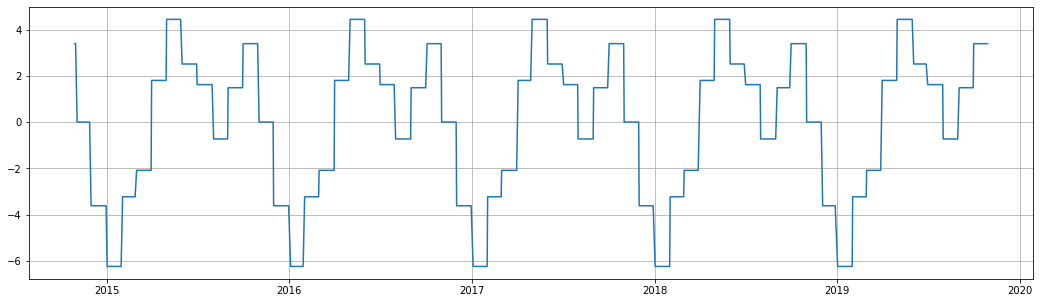

In [13]:
rcParams['figure.figsize'] = 18,5
seasonal_component = copy.deepcopy(opec)
for date in seasonal.index:
    seasonal_component.loc[seasonal_component.index.month == date, 'Value'] = seasonal.loc[date]
plt.plot(seasonal_component)
plt.grid()
plt.show()

## Removing seasonality from data.

The **seasonal_component** so obtained in the previous step is subtracted from the dataset.<br>
The **deseasonal** data so obtained will contain the actual trend and the noise components.

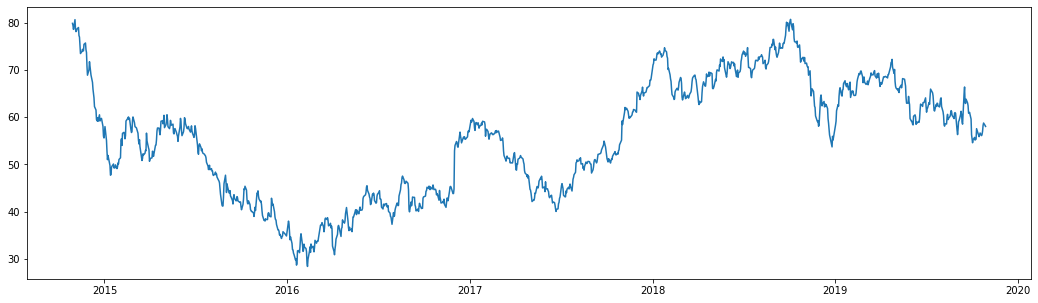

In [14]:
deseasonal = opec - seasonal_component
plt.plot(deseasonal)

## Extracting the Trend component

Steps similar to the ones taken for deriving a theoretical trend of the dataset are followed to get the trend for the **deseasonal** data.<br>
This is the actual trend in our dataset.

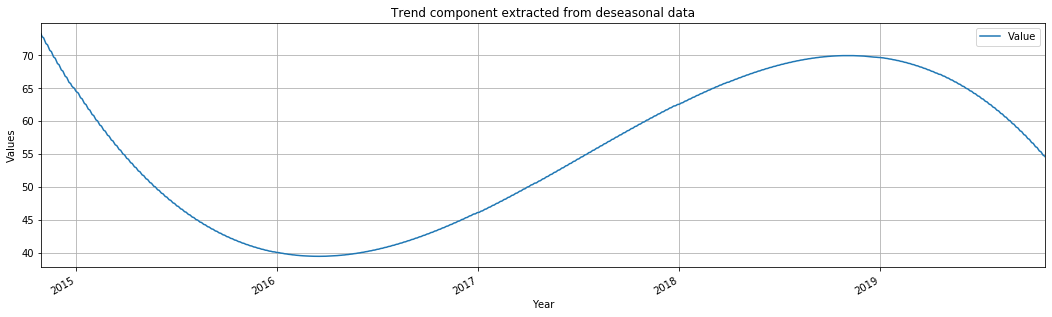

In [15]:
order = 3
coef = np.polyfit(np.arange(len(deseasonal)),
                 deseasonal['Value'].values.ravel(),
                 order)

poly_mdl = np.poly1d(coef)

trend_component = pd.DataFrame(data = poly_mdl(np.arange(len(opec['Value']))),
                          index = opec.index,
                          columns=['Value'])
trend_component.plot()
plt.title('Trend component extracted from deseasonal data')
plt.xlabel('Year')
plt.ylabel('Values')
plt.grid()

The following graph shows the comparision between the theoretical trend and the actual trend derived.

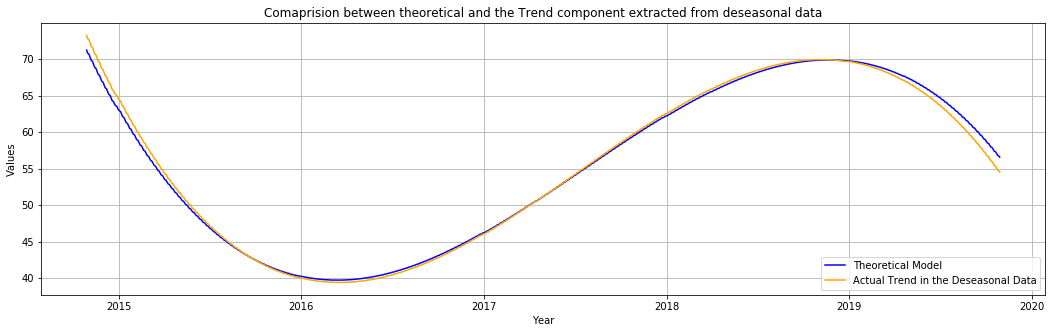

In [16]:
rcParams['figure.figsize'] = 18, 5
plt.plot(trend, color='blue', label='Theoretical Model')
plt.plot(trend_component, color='orange', label='Actual Trend in the Deseasonal Data')
plt.title('Comaprision between theoretical and the Trend component extracted from deseasonal data')
plt.xlabel('Year')
plt.ylabel('Values')
plt.grid()
plt.legend()
plt.show()

## Extracting residual data.

Finally, the residual component is the remainder of the dataset once the seasonal and trend components are subtracted from it.

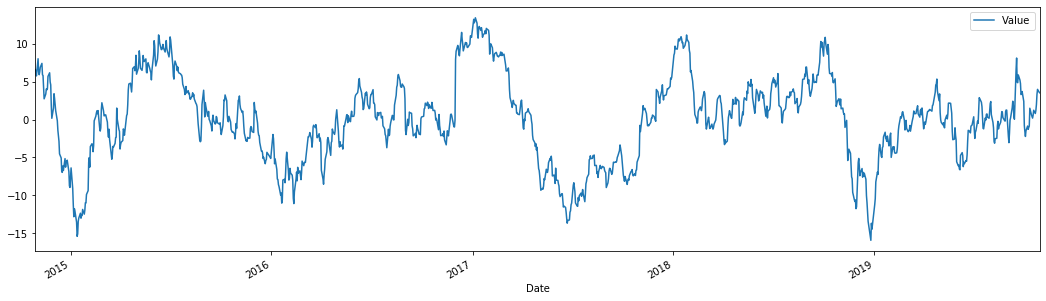

In [17]:
residual = opec - seasonal_component - trend_component
residual.plot()

## Comparing data with and without Residual component.

Here the trend and seasonal components are added and plotted along the dataset to better understand the deviations caused by residual component.

In [18]:
trend_seasonal_component = trend_component + seasonal_component

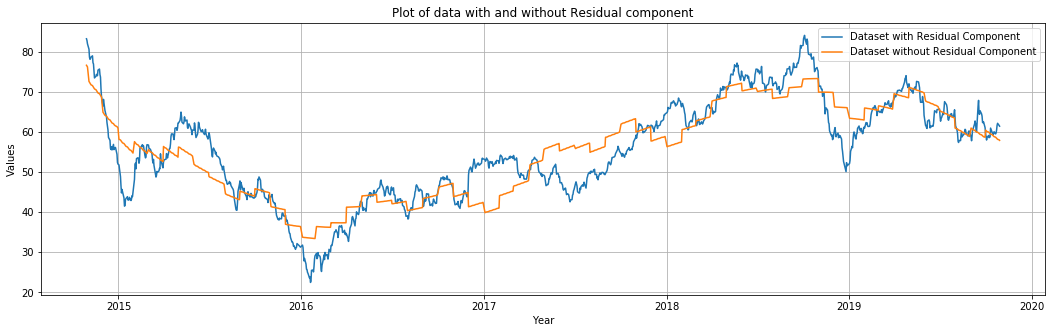

In [19]:
rcParams['figure.figsize'] = 18, 5
plt.plot(opec, label='Dataset with Residual Component')
plt.plot(trend_seasonal_component, label='Dataset without Residual Component')
plt.title('Plot of data with and without Residual component')
plt.xlabel('Year')
plt.ylabel('Values')
plt.grid()
plt.legend()
plt.show()

## Additive Decomposition using packages

The **seasonal_decompose** function in the **statsmodels** package takes care of all the above steps and outputs the 3 components - Trend, Seasonality and Residual. 

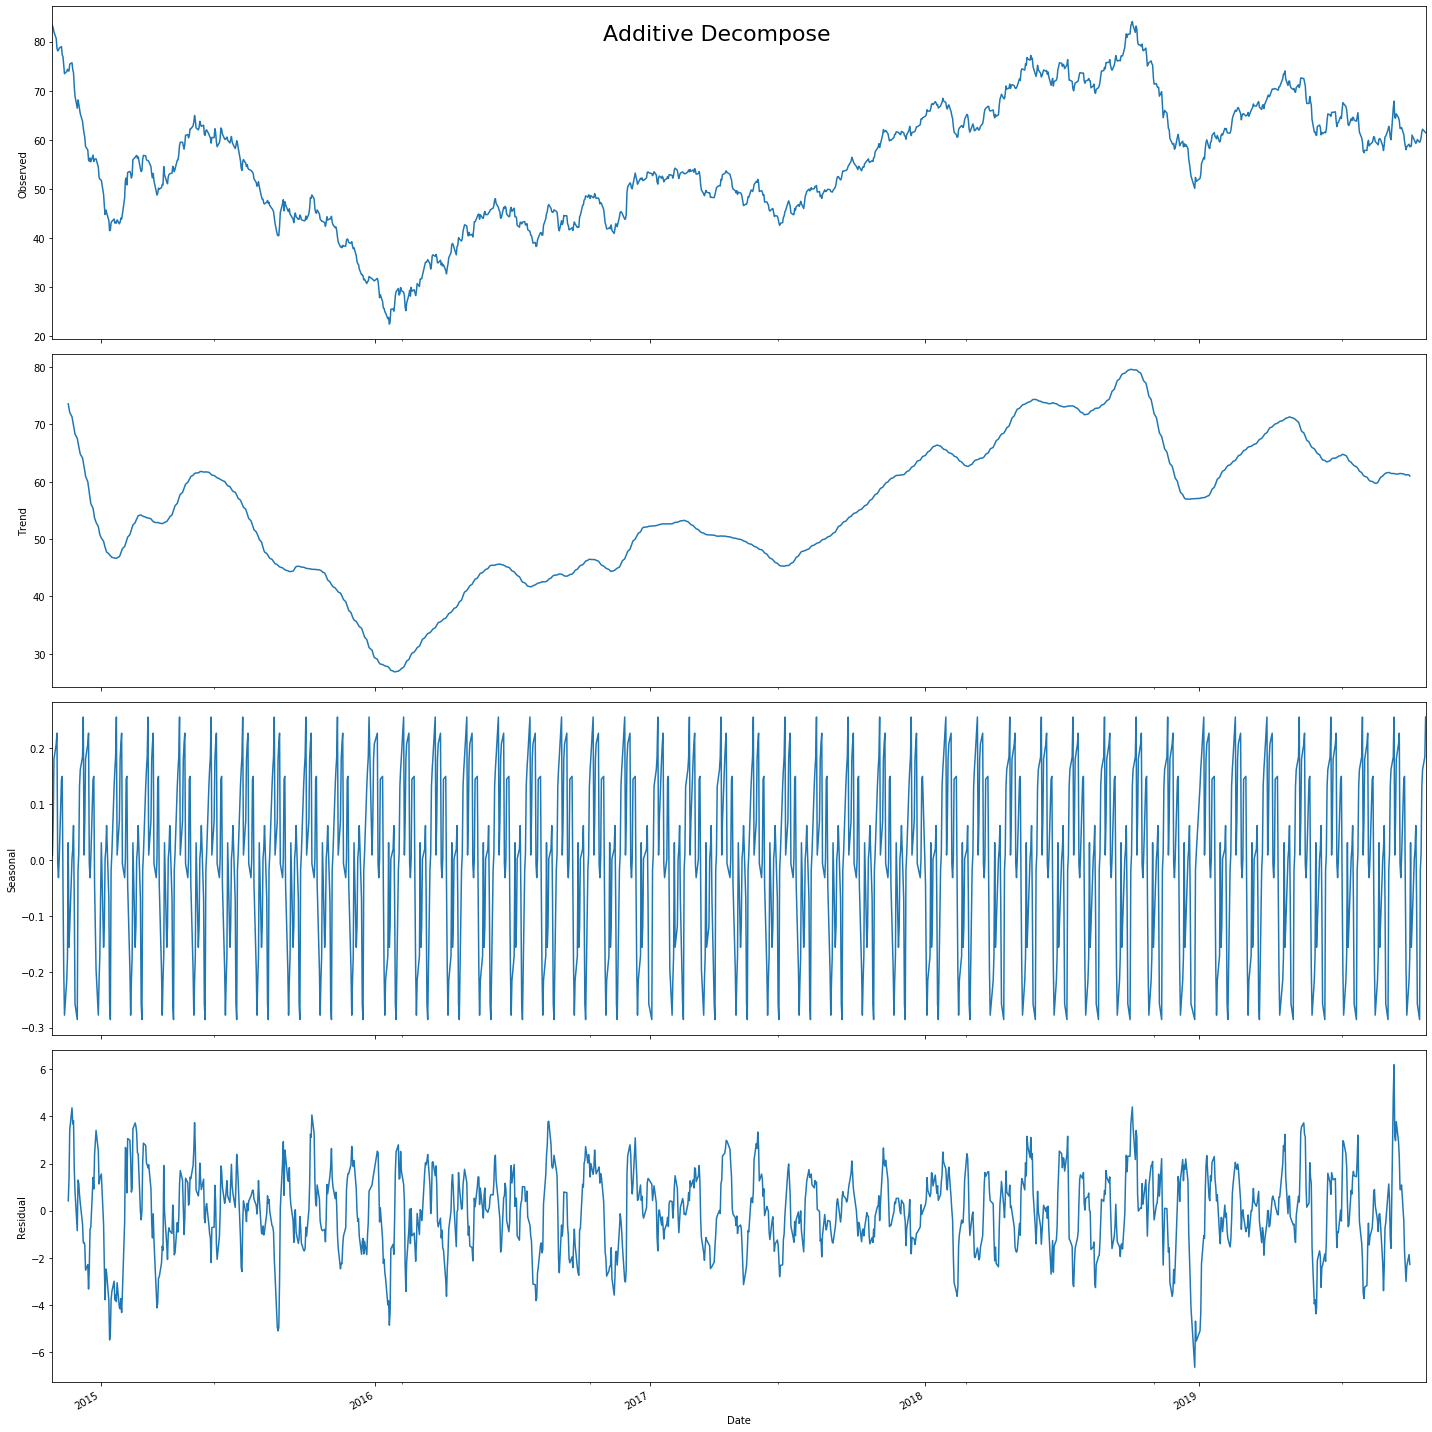

In [20]:
additive_decomposition_opec = seasonal_decompose(opec['Value'], model='additive', freq = 30)

# Prefered figure size for single plots.
# plt.rcParams.update({'figure.figsize': (18,5)})

# Prefered figure size for a plot of all 4 components - Observed, Trend, Seasonality and Residual.
plt.rcParams.update({'figure.figsize': (20,20)})

additive_decomposition_opec.plot().suptitle('Additive Decompose', fontsize=22)

# additive_decomposition_opec.trend.plot()
# additive_decomposition_opec.seasonal.plot()
# additive_decomposition_opec.resid.plot()

plt.show()

## References
- [Rob J Hyndman and George Athanasopoulos - Forcasting Principles and Practice](https://otexts.com/fpp2/)
- [Playing with time series data in python](https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8)
- [Seasonality in Python: additive or multiplicative model?](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7)
- [How to Decompose Time Series Data into Trend and Seasonality](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)
- [Time Series Decomposition from Scratch](https://github.com/bhattbhavesh91/time-series-decomposition-from-scratch)